### User Story 5 : Classification supervisée et évaluation des modèles

In [13]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# df = pd.read_csv("../data/cleaned_data_clusters.csv")
df_scaled = pd.read_csv("../data/scaled_data_clusters.csv")


#### 1- Définir la variable cible y à partir de la colonne Cluster.
#### 2- Définir X à partir des variables sélectionnées.

##### Defining X and y

- **X** is the set of features we will use to predict the risk.  
- **y** is the target, which is the `risk_category` (High risk or Low risk).  
- We check the target values to see if the classes are balanced.

In [43]:
features = ['Glucose', 'Age', 'BloodPressure', 'SkinThickness', 'BMI', 'Insulin_log', 'DiabetesPedigreeFunction_log']

X = df_scaled[features]
y = df_scaled['Cluster']


print("X shape:", X.shape)
print(f"y value counts: \n", y.value_counts())



X shape: (735, 7)
y value counts: 
 Cluster
0    384
1    351
Name: count, dtype: int64


<Axes: ylabel='count'>

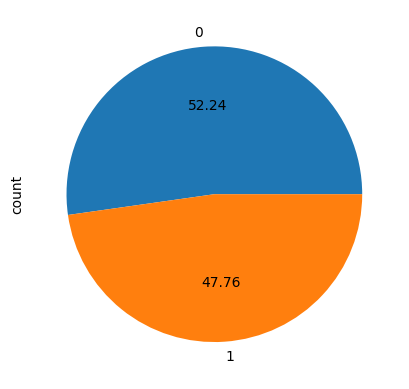

In [44]:
y.value_counts().plot.pie(autopct = '%.2f')

#### 3- Diviser les données en ensemble d’entraînement et de test à l’aide de traintestsplit.


In [45]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train value counts:\n", y_train.value_counts())
print("y_test value counts:\n", y_test.value_counts())


X_train shape: (588, 7)
X_test shape: (147, 7)
y_train value counts:
 Cluster
0    307
1    281
Name: count, dtype: int64
y_test value counts:
 Cluster
0    77
1    70
Name: count, dtype: int64


##### Splitting the data
- 80% of the data is for training, 20% for testing.    
- `stratify=y` keeps the High/Low risk ratio the same in both sets.

#### 4- Gérer le déséquilibre des classes avec des techniques de sur-échantillonnage ou sous-échantillonnage (RandomOverSampler, UnderSampler via imblearn).

In [46]:
from imblearn.under_sampling import RandomUnderSampler , TomekLinks
from imblearn.over_sampling import RandomOverSampler , SMOTE , ADASYN

# removes samples from the majority class

rus = RandomUnderSampler(random_state= 42 )
X_rus , y_rus = rus.fit_resample(X , y)


risk_category
High risk    351
Low risk     351
Name: count, dtype: int64


<Axes: ylabel='count'>

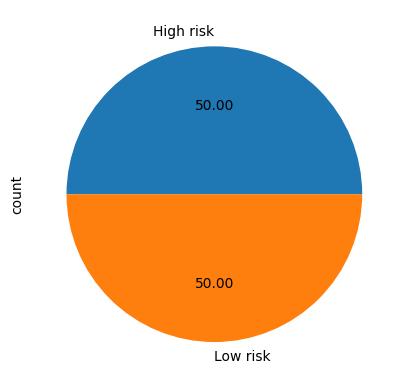

In [33]:
print(y_rus.value_counts())
y_rus.value_counts().plot.pie(autopct = '%.2f')

risk_category
High risk    384
Low risk     384
Name: count, dtype: int64


<Axes: ylabel='count'>

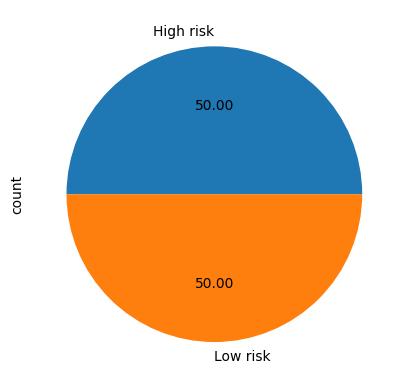

In [34]:
# duplecates samples from the minority class

ros = RandomOverSampler(random_state= 42 )
X_ros , y_ros = ros.fit_resample(X , y)
print(y_ros.value_counts())
y_ros.value_counts().plot.pie(autopct = '%.2f')

In [47]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("Before SMOTE:", y_train.value_counts())
print("After SMOTE:", y_train_smote.value_counts())

Before SMOTE: Cluster
0    307
1    281
Name: count, dtype: int64
After SMOTE: Cluster
1    307
0    307
Name: count, dtype: int64


We apply SMOTE only on the training data to balance the classes by creating synthetic examples for the minority class.

#### 5- Tester les algorithmes suivants : Random Forest, SVM, Gradient Boosting, Decision Tree, Régression Logistique , XGB.

In [48]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score,
    recall_score, f1_score, classification_report
)


In [ ]:


# Define models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "SVM": SVC(kernel='rbf', probability=True, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "XGBoost": XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
}

#  Where i store results 
metrics_results = []
confusion_matrices = {}

#  Train and evaluate each model 

for name, model in models.items():
    model.fit(X_train_smote, y_train_smote)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, pos_label=1)
    rec = recall_score(y_test, y_pred, pos_label=1)
    f1 = f1_score(y_test, y_pred, pos_label=1)

    # Store metrics
    metrics_results.append({
        "Model": name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1-score": f1
    })

    # Store confusion matrix (as DataFrame for easy reading)
    cm = confusion_matrix(y_test, y_pred)
    confusion_matrices[name] = pd.DataFrame(
        cm)

#  Summary metrics table 
metrics_df = pd.DataFrame(metrics_results).set_index("Model").sort_values(by="F1-score", ascending=False)



 Model Comparison 


c:\Users\kaout\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:36:50] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,Accuracy,Precision,Recall,F1-score
Model,,,,
Logistic Regression,0.993197,0.985915,1.000000,0.992908
SVM,0.979592,0.985507,0.971429,0.978417
XGBoost,0.959184,0.944444,0.971429,0.957746
Gradient Boosting,0.959184,0.944444,0.971429,0.957746
Random Forest,0.959184,0.957143,0.957143,0.957143
Decision Tree,0.891156,0.864865,0.914286,0.888889



 Confusion Matrices (for all models) 

Logistic Regression:
    0   1
0  76   1
1   0  70


Decision Tree:
    0   1
0  67  10
1   6  64


Random Forest:
    0   1
0  74   3
1   3  67


SVM:
    0   1
0  76   1
1   2  68


Gradient Boosting:
    0   1
0  73   4
1   2  68


XGBoost:
    0   1
0  73   4
1   2  68



 Model Comparison 


,Accuracy,Precision,Recall,F1-score
Model,,,,
Logistic Regression,1.000000,1.000000,1.000000,1.000000
SVM,1.000000,1.000000,1.000000,1.000000
XGBoost,0.972789,0.958333,0.985714,0.971831



Logistic Regression:
    0   1
0  76   1
1   0  70



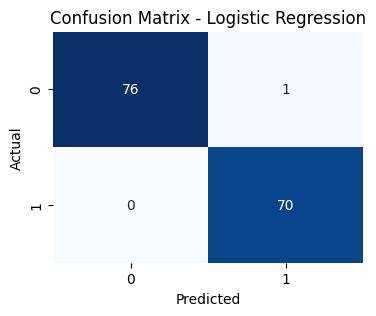


Decision Tree:
    0   1
0  67  10
1   6  64



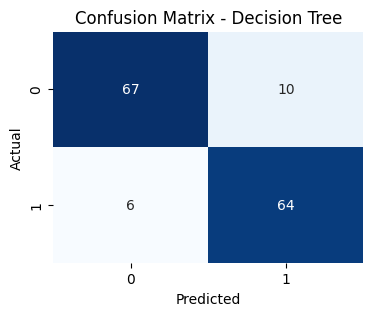


Random Forest:
    0   1
0  74   3
1   3  67



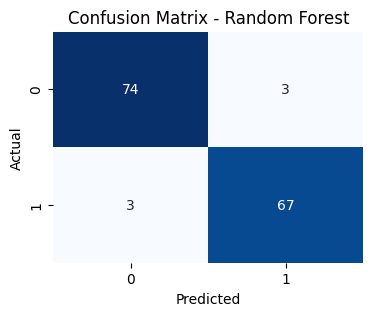


SVM:
    0   1
0  76   1
1   2  68



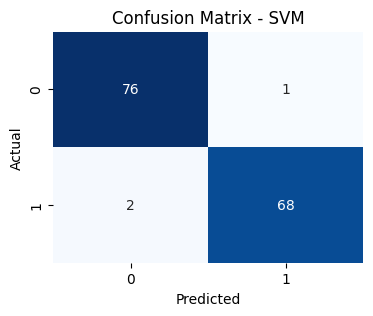


Gradient Boosting:
    0   1
0  73   4
1   2  68



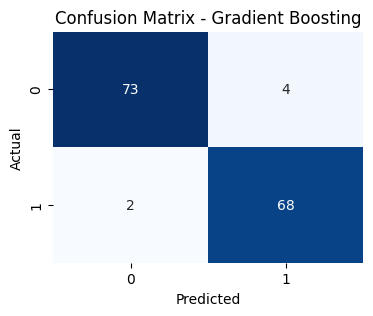


XGBoost:
    0   1
0  73   4
1   2  68



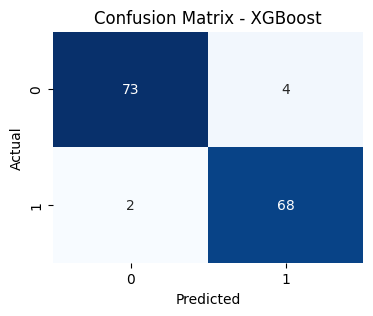

In [77]:

print(" Model Comparison ")
display(metrics_df)

for name, cm in confusion_matrices.items():
    print(f"\n{name}:\n{cm}\n")

    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

##### Model Evaluation

Logistic Regression, SVM, and XGBoost were evaluated.  
- Logistic Regression performed best (F1 = 0.993), capturing nearly all high-risk cases.  
- SVM and XGBoost also performed well but missed a few high-risk individuals.  

Overall, Logistic Regression is the most reliable for identifying high-risk patients.


#### 7- Évaluer la robustesse des modèles sur différentes partitions du jeu de données en utilisant la validation croisée (cross-validation).

In [62]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score


In [ ]:

# Define models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "SVM": SVC(kernel='rbf', probability=True, random_state=42),
    "XGBoost": XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
}

# Define cross-validation setup
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define multiple scoring metrics
scoring = ['accuracy', 'precision', 'recall', 'f1']

# Store results
cv_results = {}

for name, model in models.items():
    scores = cross_validate(model, X_train_smote, y_train_smote,
                            cv=kfold, scoring=scoring, n_jobs=-1)
    
    cv_results[name] = {  metric: scores[f'test_{metric}'].mean() for metric in scoring }

cv_results_df = pd.DataFrame(cv_results).T
cv_results_df = cv_results_df.sort_values(by='f1', ascending=False)

print("Cross-validation average results:")
display(cv_results_df)


Cross-validation average results:


,accuracy,precision,recall,f1
Logistic Regression,0.986992,0.984212,0.990270,0.987119
SVM,0.970678,0.973823,0.967478,0.970624
XGBoost,0.931601,0.935216,0.928503,0.931684


Stratified K-Fold Cross-Validation

I used Stratified K-Fold to test the 3 best models: Logistic Regression, SVM, and XGBoost. This just makes sure that in every split, the proportion of High risk / Low risk stays the same.

For each fold, we calculate accuracy, precision, recall, and F1-score, then take the average. This way, we see how the model really performs, not just based on one random split.

It’s basically testing the model many times and checking the scores to be sure it’s stable.

**Interpretation:**
- Logistic Regression performed the best overall with the highest F1-score and balanced precision/recall.
- SVM is slightly lower but still very good.
- XGBoost is okay, but clearly worse than the other two for this dataset.
- Based on this, **Logistic Regression** seems like the most reliable model for classifying high vs low diabetes risk.

#### 8- Utiliser des techniques comme GridSearchCV ou RandomizedSearchCV pour affiner les hyperparamètres des modèles et améliorer leurs performances.

In [64]:
from sklearn.model_selection import RandomizedSearchCV

In [66]:

models_and_params = {
    "Logistic Regression": {
        "model": LogisticRegression(max_iter=1000, random_state=42),
        "params": {
            "C": [0.01, 0.1, 1, 10, 100],
            "penalty": ["l1", "l2"],
            "solver": ["liblinear"]
        }
    },
    "SVM": {
        "model": SVC(probability=True, random_state=42),
        "params": {
            "C": [0.1, 1, 10, 100],
            "kernel": ["linear", "rbf", "poly"],
            "gamma": ["scale", "auto"]
        }
    },
    "XGBoost": {
        "model": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
        "params": {
            "n_estimators": [50, 100, 200],
            "max_depth": [3, 5, 7],
            "learning_rate": [0.01, 0.1, 0.2],
            "subsample": [0.7, 0.8, 1.0]
        }
    }
}

In [ ]:
best_results = {}

# Loop through each model and apply RandomizedSearchCV
for name, mp in models_and_params.items():
    # print(f"\nOptimizing {name}...")
    model = mp["model"]
    param_grid = mp["params"]

    search = RandomizedSearchCV(model, param_grid, n_iter=10, scoring='f1', cv=5, random_state=42)
    search.fit(X_train_smote, y_train_smote)

    best_results[name] = {
        "best_params": search.best_params_,
        "best_estimator": search.best_estimator_
    }
    # print(f"Best params for {name}: {search.best_params_}")

 

c:\Users\kaout\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:04:03] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\kaout\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:04:03] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\kaout\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:04:03] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\kaout\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:04:04] WARNING: C:\actio

{'Logistic Regression': {'best_params': {'solver': 'liblinear', 'penalty': 'l1', 'C': 10}, 'best_estimator': LogisticRegression(C=10, max_iter=1000, penalty='l1', random_state=42,
                   solver='liblinear')}, 'SVM': {'best_params': {'kernel': 'linear', 'gamma': 'scale', 'C': 100}, 'best_estimator': SVC(C=100, kernel='linear', probability=True, random_state=42)}, 'XGBoost': {'best_params': {'subsample': 0.8, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1}, 'best_estimator': XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None,

c:\Users\kaout\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:04:06] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\kaout\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:04:06] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\kaout\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:04:06] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [70]:
for model , result in best_results.items():
    print(f"=========={model }================", "\n")
    print(result)

==========Logistic Regression================ 

{'best_params': {'solver': 'liblinear', 'penalty': 'l1', 'C': 10}, 'best_estimator': LogisticRegression(C=10, max_iter=1000, penalty='l1', random_state=42,
                   solver='liblinear')}
==========SVM================ 

{'best_params': {'kernel': 'linear', 'gamma': 'scale', 'C': 100}, 'best_estimator': SVC(C=100, kernel='linear', probability=True, random_state=42)}
==========XGBoost================ 

{'best_params': {'subsample': 0.8, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1}, 'best_estimator': XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None

**Randomized Search**:
- I tried different hyperparameters for each model.
- It gives the best params and best model automatically.
- This is before testing, to make models better.

#### 9- Comparer les performances des différents modèles.


In [74]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Store results
metrics_results = []

for name, result in best_results.items():
    model = result['best_estimator']
    y_pred = model.predict(X_test)

    metrics_results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, pos_label=1),
        "Recall": recall_score(y_test, y_pred, pos_label=1),
        "F1-score": f1_score(y_test, y_pred, pos_label=1)
    })

# Convert to DataFrame for easier comparison
metrics_df = pd.DataFrame(metrics_results).set_index("Model").sort_values(by="F1-score", ascending=False)
display(metrics_df)


,Accuracy,Precision,Recall,F1-score
Model,,,,
Logistic Regression,1.000000,1.000000,1.000000,1.000000
SVM,1.000000,1.000000,1.000000,1.000000
XGBoost,0.972789,0.958333,0.985714,0.971831


**Model Results:**
- Now we test the models with the tuned params.
- Collect Accuracy, Precision, Recall, F1-score for each.
- Helps me see which model works best.

ok so after applying RandomizedSearchCV on the three models i see that:  
- Logistic Regression gives perfect scores, everything is 1, so really strong  
- SVM also gives perfect scores, exactly the same, so also excellent  
- XGBoost is very good too, accuracy around 0.97 and F1 0.97, but not perfect like the others  

so in conclusion, LR and SVM are the best here, and XGBoost is strong if we want a tree-based model


#### 10- Choisir le modèle le plus performant.


I will use Logistic Regression as the final model because it gave the best results.  
I chose it over XGBoost even though both performed very well, mainly because it is simpler and more interpretable.


In [75]:
# Extract the best estimator from the RandomizedSearchCV results
final_model = best_results['Logistic Regression']['best_estimator']


#### 11- Sauvegarder le modèle final dans un fichier (ex. : model.pkl).


In [76]:
import joblib

# Save the final model to a file
joblib.dump(final_model, '../models/final_model.pkl')

# To load the model later
# loaded_model = joblib.load('final_model.pkl')


['../models/final_model.pkl']

In [78]:
print(X_train_smote.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 7 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Glucose                       614 non-null    float64
 1   Age                           614 non-null    float64
 2   BloodPressure                 614 non-null    float64
 3   SkinThickness                 614 non-null    float64
 4   BMI                           614 non-null    float64
 5   Insulin_log                   614 non-null    float64
 6   DiabetesPedigreeFunction_log  614 non-null    float64
dtypes: float64(7)
memory usage: 33.7 KB
None
